In [ ]:
!pip install yfinance pmdarima statsmodels arch
!pip install ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=e52acf75a86988c4f155468d222bed83963ab7b710f755a8169ae6ff6625b34f
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import itertools
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from arch import arch_model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

[*********************100%%**********************]  1 of 1 completed


New best model found: order=(0, 0, 0), seasonal_order=(0, 0, 0, 12), trend=n, MSE=48775.32099686001
New best model found: order=(0, 0, 0), seasonal_order=(0, 0, 0, 12), trend=c, MSE=5096.447473867453
New best model found: order=(0, 0, 0), seasonal_order=(1, 0, 0, 12), trend=t, MSE=2033.889467319601
New best model found: order=(0, 0, 0), seasonal_order=(1, 0, 0, 12), trend=ct, MSE=1229.9159131250842
New best model found: order=(1, 0, 2), seasonal_order=(1, 0, 0, 12), trend=t, MSE=1154.8847633345256
New best model found: order=(2, 0, 0), seasonal_order=(0, 1, 1, 12), trend=t, MSE=791.2198588796069
New best model found: order=(2, 0, 0), seasonal_order=(0, 1, 1, 12), trend=ct, MSE=704.4707738506085
Best model: order=(2, 0, 0), seasonal_order=(0, 1, 1, 12), trend=ct, MSE=704.4707738506085


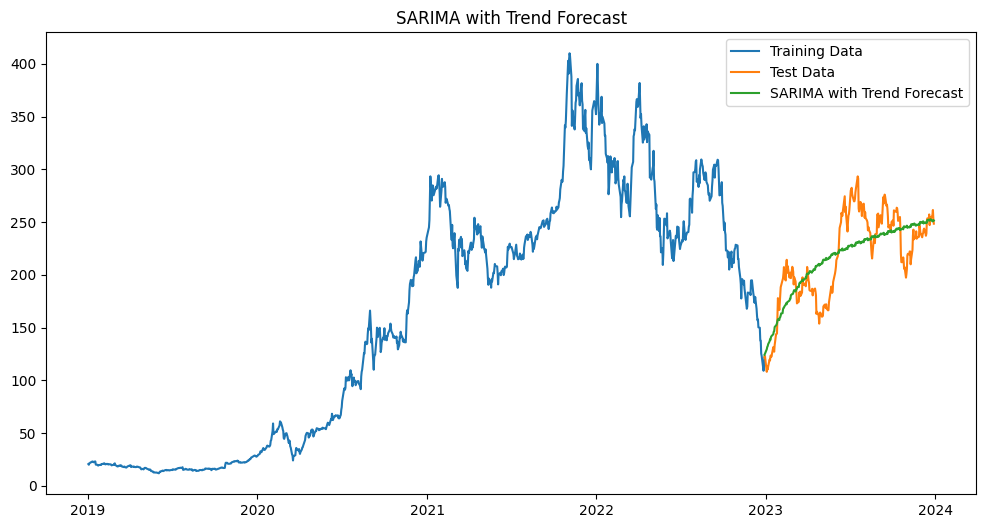

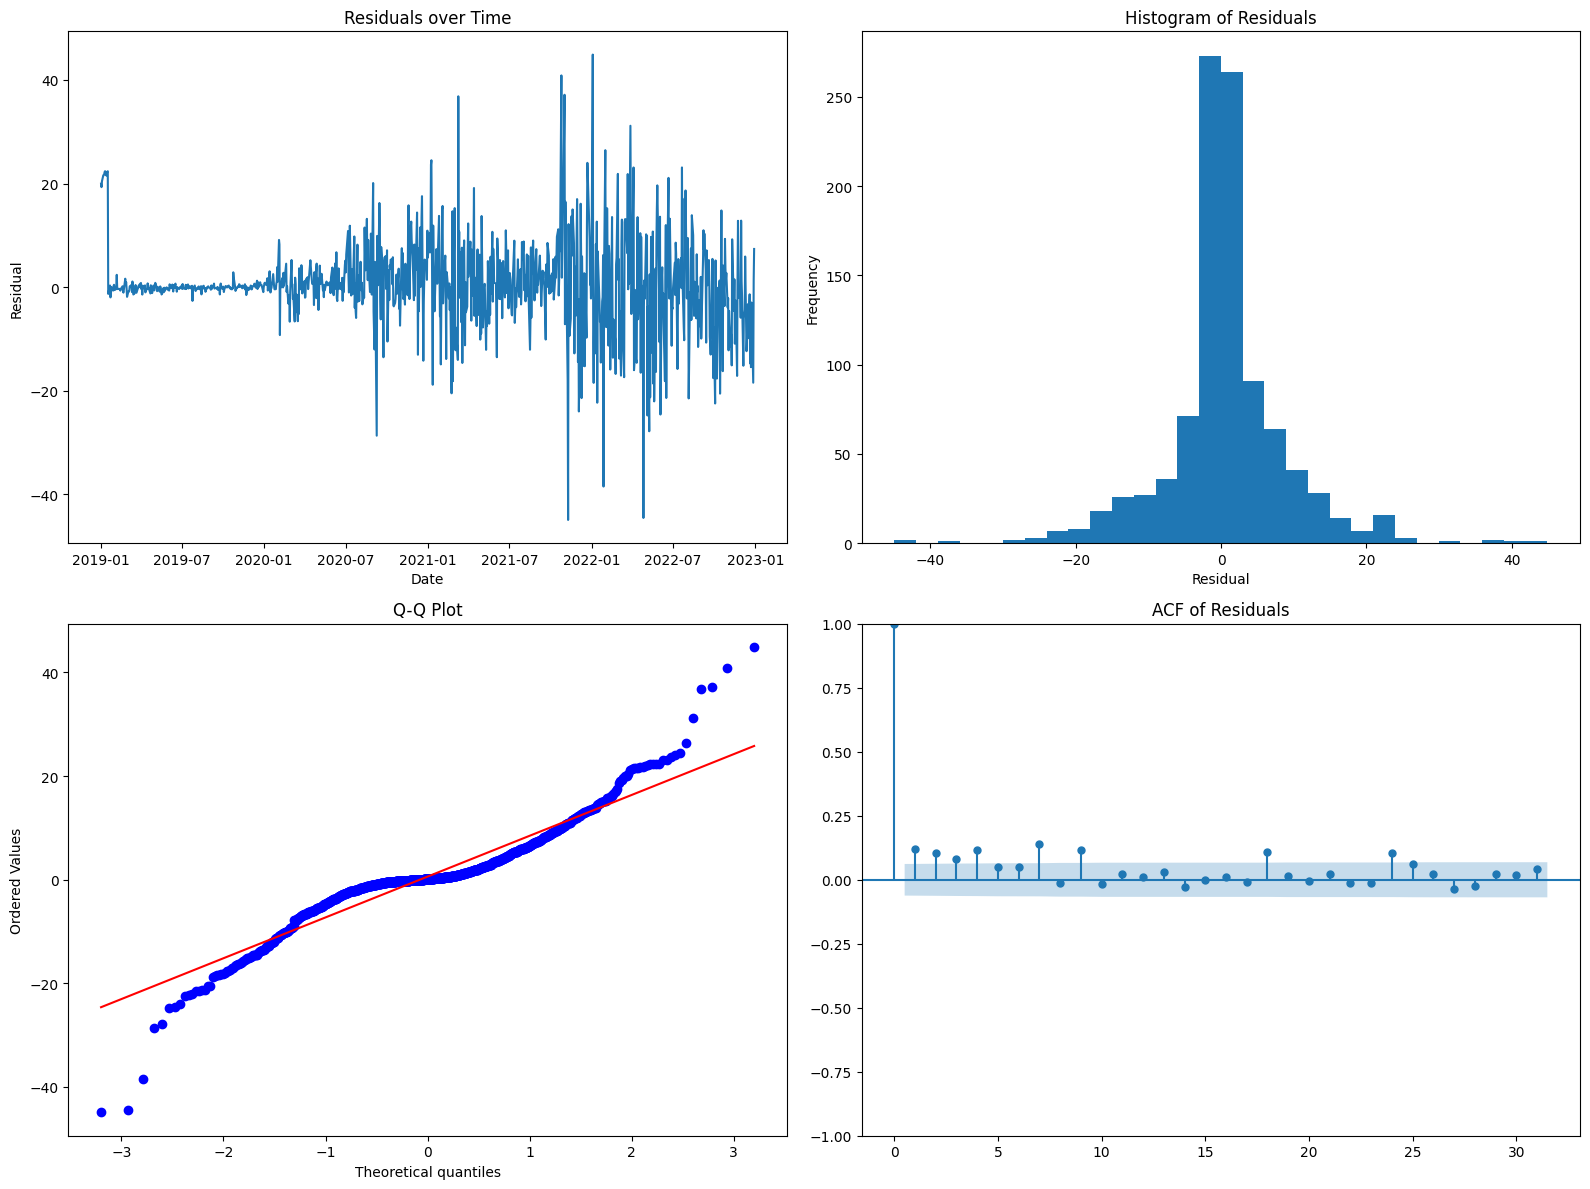

Ljung-Box test results:
       lb_stat     lb_pvalue
10   85.028641  5.152286e-14
20  100.138685  1.189632e-12
30  119.861436  1.076283e-12
SARIMA with Trend grid search completed successfully.


In [ ]:
import itertools
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

class SARIMA_Trend_Model:
    def __init__(self, train, test, target_column):
        self.train = train
        self.test = test
        self.target_column = target_column
        self.best_sarima_model = None
        self.best_sarima_results = None
        self.best_forecast = None
        self.best_forecast_mean = None
        self.best_mse = float('inf')
        self.best_order = None
        self.best_seasonal_order = None

    def fit_sarima(self, order=(1,1,1), seasonal_order=(0,0,0,0), trend='n'):
        try:
            model = SARIMAX(self.train[self.target_column], order=order, seasonal_order=seasonal_order, trend=trend)
            results = model.fit(disp=False)
            return results
        except Exception as e:
            print(f"An error occurred while fitting the SARIMA model with order={order}, seasonal_order={seasonal_order}, trend={trend}: {e}")
            return None

    def make_forecast(self, sarima_results):
        forecast = sarima_results.get_forecast(steps=len(self.test))
        forecast_mean = forecast.predicted_mean
        return forecast_mean

    def evaluate_model(self, forecast_mean):
        mse = mean_squared_error(self.test[self.target_column], forecast_mean)
        return mse

    def plot_results(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train[self.target_column], label='Training Data')
        plt.plot(self.test.index, self.test[self.target_column], label='Test Data')
        plt.plot(self.test.index, self.best_forecast_mean, label='SARIMA with Trend Forecast')
        plt.title('SARIMA with Trend Forecast')
        plt.legend()
        plt.show()

    def residual_diagnostics(self):
        residuals = self.best_sarima_results.resid
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Residuals over time
        axes[0, 0].plot(residuals)
        axes[0, 0].set_title('Residuals over Time')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Residual')

        # Histogram of residuals
        axes[0, 1].hist(residuals, bins=30)
        axes[0, 1].set_title('Histogram of Residuals')
        axes[0, 1].set_xlabel('Residual')
        axes[0, 1].set_ylabel('Frequency')

        # Q-Q plot
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot')

        # ACF of residuals
        from statsmodels.graphics.tsaplots import plot_acf
        plot_acf(residuals, ax=axes[1, 1])
        axes[1, 1].set_title('ACF of Residuals')

        plt.tight_layout()
        plt.show()

        # Ljung-Box test
        from statsmodels.stats.diagnostic import acorr_ljungbox
        lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30])
        print("Ljung-Box test results:")
        print(lb_test)

    def run_grid_search(self, p_values, d_values, q_values, P_values, D_values, Q_values, m_values, trend_options):
        for order in itertools.product(p_values, d_values, q_values):
            for seasonal_order in itertools.product(P_values, D_values, Q_values, m_values):
                for trend in trend_options:
                    sarima_results = self.fit_sarima(order=order, seasonal_order=seasonal_order, trend=trend)
                    if sarima_results is not None:
                        forecast_mean = self.make_forecast(sarima_results)
                        mse = self.evaluate_model(forecast_mean)
                        if mse < self.best_mse:
                            self.best_mse = mse
                            self.best_order = order
                            self.best_seasonal_order = seasonal_order
                            self.best_trend = trend
                            self.best_sarima_results = sarima_results
                            self.best_forecast_mean = forecast_mean
                            print(f"New best model found: order={order}, seasonal_order={seasonal_order}, trend={trend}, MSE={mse}")

        print(f"Best model: order={self.best_order}, seasonal_order={self.best_seasonal_order}, trend={self.best_trend}, MSE={self.best_mse}")
        self.plot_results()
        self.residual_diagnostics()

# Download data
TICKER = "TSLA"
target_column = 'Close'
df = yf.download(TICKER, start="2023-01-01", end="2023-02-01").reset_index()

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training and test sets
split_date = df.index[int(len(df) * 0.8)]
train = df[:split_date]
test = df[split_date:]

# Parameters for grid search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
m_values = [12]  # seasonal period (e.g., 12 for monthly seasonality)
trend_options = ['n', 'c', 't', 'ct']  # 'n' = no trend, 'c' = constant, 't' = linear trend, 'ct' = both

# Create an instance of SARIMA_Trend_Model
sarima_trend_model = SARIMA_Trend_Model(train=train, test=test, target_column=target_column)

# Run grid search with SARIMA and Trend component
sarima_trend_model.run_grid_search(p_values, d_values, q_values, P_values, D_values, Q_values, m_values, trend_options)

print("SARIMA with Trend grid search completed successfully.")


[*********************100%%**********************]  1 of 1 completed


New best model found: order=(0, 0, 0), seasonal_order=(0, 0, 0, 12), trend=n, MSE=28778.901935354632
New best model found: order=(0, 0, 0), seasonal_order=(0, 0, 0, 12), trend=c, MSE=1816.1927195120602
New best model found: order=(0, 0, 0), seasonal_order=(0, 0, 0, 12), trend=ct, MSE=223.74751642358308
New best model found: order=(0, 0, 0), seasonal_order=(0, 1, 0, 12), trend=t, MSE=50.152270810768115
New best model found: order=(0, 0, 0), seasonal_order=(0, 1, 0, 12), trend=ct, MSE=30.311257136116975
New best model found: order=(0, 0, 0), seasonal_order=(0, 1, 1, 12), trend=ct, MSE=30.310603389090964
New best model found: order=(0, 0, 0), seasonal_order=(1, 1, 0, 12), trend=ct, MSE=30.21605954503156
New best model found: order=(1, 0, 0), seasonal_order=(0, 1, 1, 12), trend=ct, MSE=28.97141521782279
New best model found: order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), trend=c, MSE=25.77509148011854
New best model found: order=(1, 1, 0), seasonal_order=(0, 1, 1, 12), trend=c, MSE=24.9932

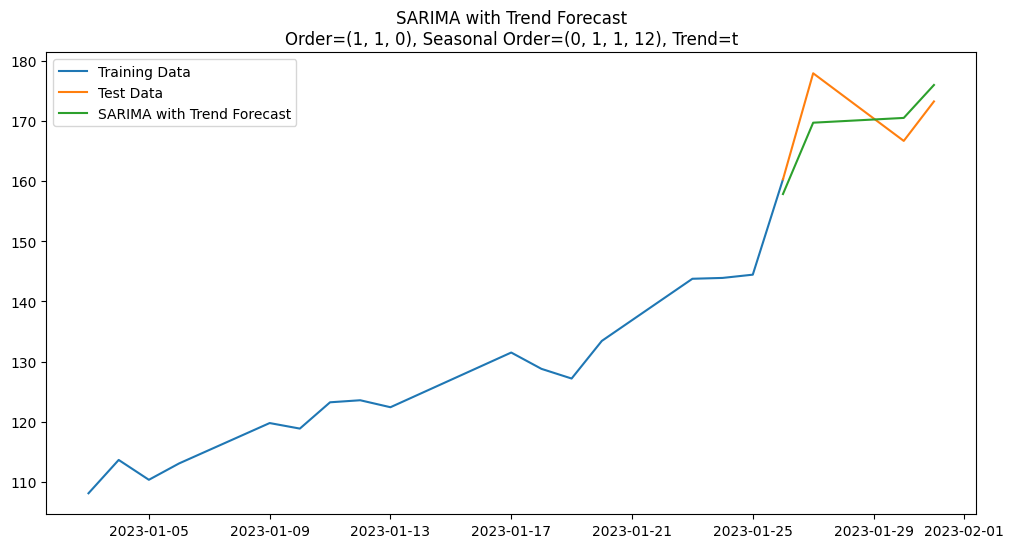

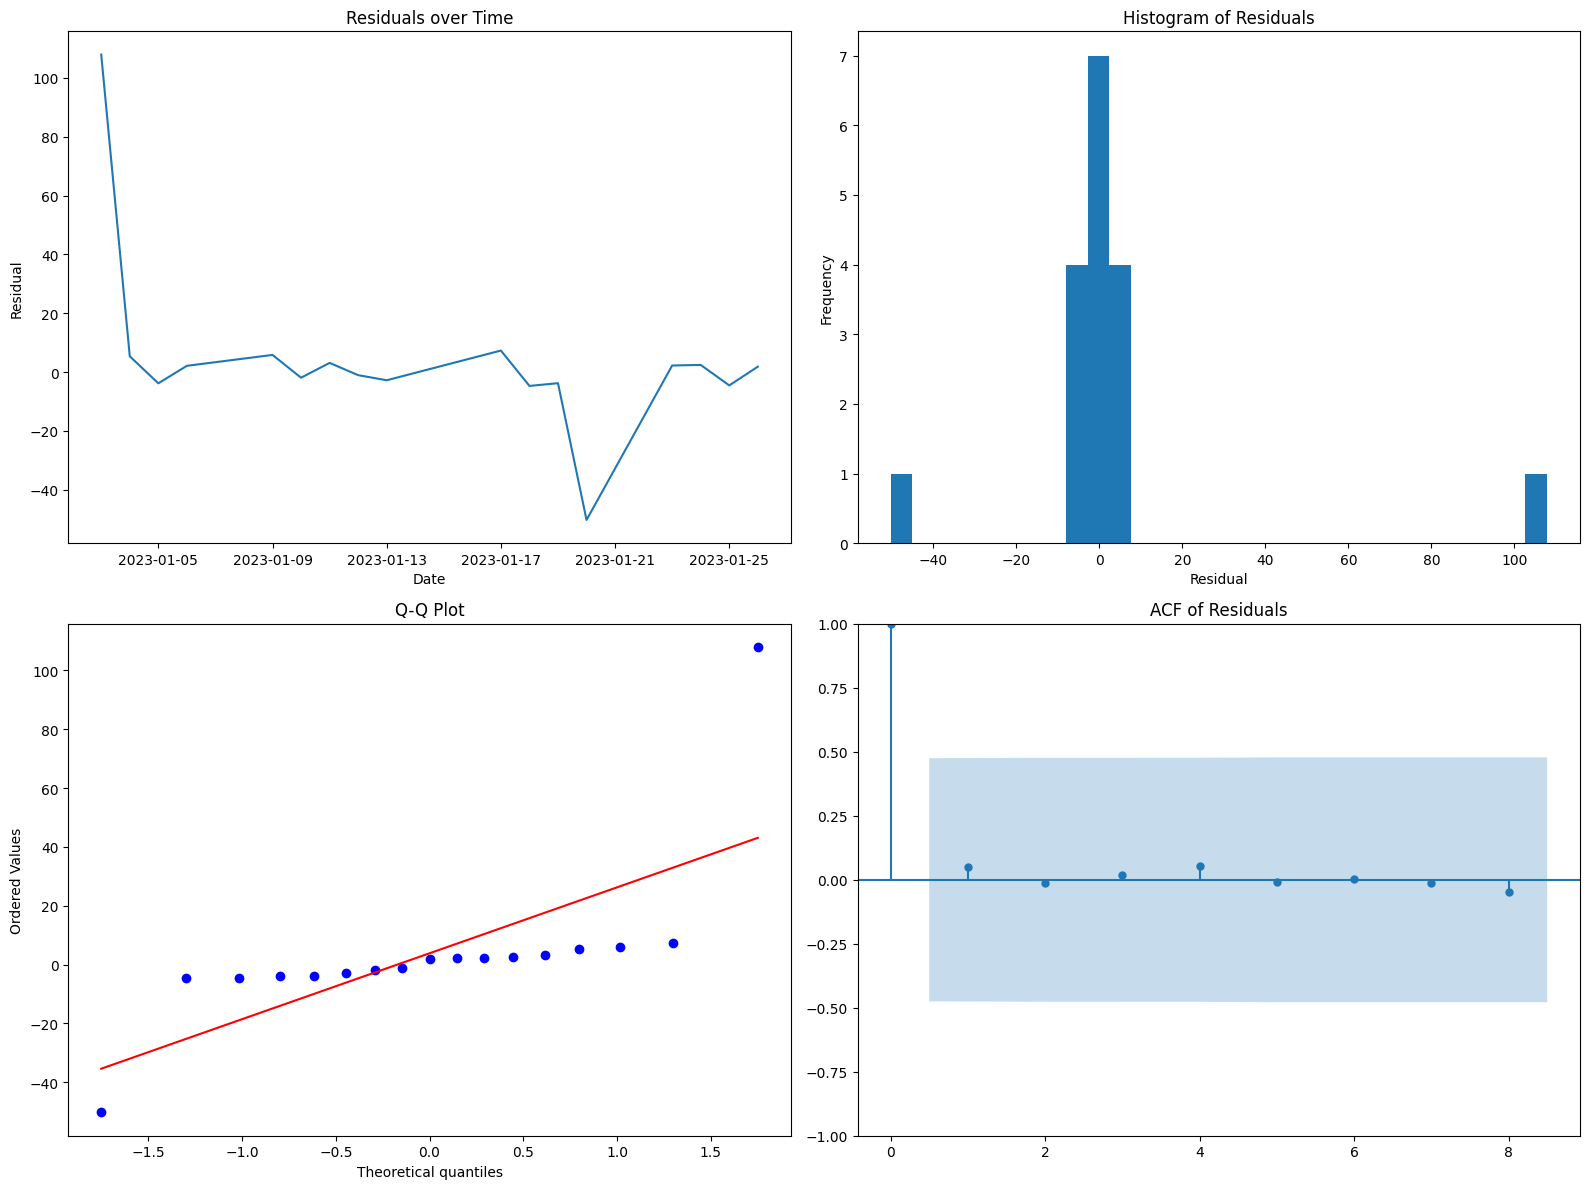

Ljung-Box test results:
    lb_stat  lb_pvalue
1  0.053346   0.817340
2  0.057382   0.971717
3  0.066502   0.995529
4  0.138045   0.997725
5  0.140403   0.999626
6  0.140568   0.999945
7  0.145686   0.999992
8  0.221023   0.999994
SARIMA with Trend grid search completed successfully.


In [ ]:
import itertools
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox


class SARIMA_Trend_Model:
    def __init__(self, train, test, target_column):
        self.train = train
        self.test = test
        self.target_column = target_column
        self.best_sarima_model = None
        self.best_sarima_results = None
        self.best_forecast = None
        self.best_forecast_mean = None
        self.best_mse = float('inf')
        self.best_order = None
        self.best_seasonal_order = None
        self.best_trend = None

    def fit_sarima(self, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), trend='n'):
        try:
            model = SARIMAX(self.train[self.target_column], order=order, seasonal_order=seasonal_order, trend=trend)
            results = model.fit(disp=False)
            return results
        except Exception as e:
            print(f"An error occurred while fitting the SARIMA model with order={order}, seasonal_order={seasonal_order}, trend={trend}: {e}")
            return None

    def make_forecast(self, sarima_results):
        forecast = sarima_results.get_forecast(steps=len(self.test))
        forecast_mean = forecast.predicted_mean
        return forecast_mean

    def evaluate_model(self, forecast_mean):
        mse = mean_squared_error(self.test[self.target_column], forecast_mean)
        return mse

    def fit_best_model(self):
        if self.best_order and self.best_seasonal_order:
            self.best_sarima_results = self.fit_sarima(order=self.best_order,
                                                       seasonal_order=self.best_seasonal_order,
                                                       trend=self.best_trend)
            self.best_forecast_mean = self.make_forecast(self.best_sarima_results)
            self.best_mse = self.evaluate_model(self.best_forecast_mean)

    # def plot_results(self):
    #     plt.figure(figsize=(12, 6))
    #     plt.plot(self.train.index, self.train[self.target_column], label='Training Data')
    #     plt.plot(self.test.index, self.test[self.target_column], label='Test Data')
    #     plt.plot(self.test.index, self.best_forecast_mean, label='SARIMA with Trend Forecast')
    #     plt.title('SARIMA with Trend Forecast')
    #     plt.legend()
    #     plt.show()

    def plot_results(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.train.index, self.train[self.target_column], label='Training Data')
        plt.plot(self.test.index, self.test[self.target_column], label='Test Data')
        plt.plot(self.test.index, self.best_forecast_mean, label='SARIMA with Trend Forecast')

        # Include model parameters in the title
        title = (
            f'SARIMA with Trend Forecast\n'
            f'Order={self.best_order}, Seasonal Order={self.best_seasonal_order}, Trend={self.best_trend}'
        )
        plt.title(title)
        plt.legend()
        plt.show()


    def plot_accuracy(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.test.index, self.test[self.target_column], label='Actual')
        plt.plot(self.test.index, self.best_forecast_mean, label='Forecast')
        plt.title('Forecast Accuracy')
        plt.legend()
        plt.show()

    def print_evaluation_metrics(self):
        print(f"Best Model MSE: {self.best_mse}")

    def display_top_orders(self, n=5):
        print(f"Best Model Order: {self.best_order}")
        print(f"Best Seasonal Order: {self.best_seasonal_order}")
        print(f"Best Trend: {self.best_trend}")

    def get_best_order(self):
        return self.best_order, self.best_seasonal_order, self.best_trend

    def get_forecast(self):
        return self.best_forecast_mean

    def residual_diagnostics(self):
        residuals = self.best_sarima_results.resid
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Residuals over time
        axes[0, 0].plot(residuals)
        axes[0, 0].set_title('Residuals over Time')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Residual')

        # Histogram of residuals
        axes[0, 1].hist(residuals, bins=30)
        axes[0, 1].set_title('Histogram of Residuals')
        axes[0, 1].set_xlabel('Residual')
        axes[0, 1].set_ylabel('Frequency')

        # Q-Q plot
        stats.probplot(residuals, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title('Q-Q Plot')

        # ACF of residuals
        plot_acf(residuals, ax=axes[1, 1])
        axes[1, 1].set_title('ACF of Residuals')

        plt.tight_layout()
        plt.show()

        # Ljung-Box test with limited lags
        max_lags = min(len(residuals) // 2, 10)  # Ensure lags are not more than half of the residual length
        lb_test = acorr_ljungbox(residuals, lags=[i for i in range(1, max_lags + 1)])
        print("Ljung-Box test results:")
        print(lb_test)


    def plot_acf_pacf(self, lags=50):
        max_lags = min(lags, len(self.train) // 2)  # Ensure the number of lags doesn't exceed half the data length

        fig, ax = plt.subplots(1, 2, figsize=(16, 6))
        plot_acf(self.train[self.target_column], lags=max_lags, ax=ax[0])
        ax[0].set_title('Autocorrelation Function')
        plot_pacf(self.train[self.target_column], lags=max_lags, ax=ax[1])
        ax[1].set_title('Partial Autocorrelation Function')
        plt.show()


    def run_grid_search(self, p_values, d_values, q_values, P_values, D_values, Q_values, m_values, trend_options):
        for order in itertools.product(p_values, d_values, q_values):
            for seasonal_order in itertools.product(P_values, D_values, Q_values, m_values):
                for trend in trend_options:
                    sarima_results = self.fit_sarima(order=order, seasonal_order=seasonal_order, trend=trend)
                    if sarima_results is not None:
                        forecast_mean = self.make_forecast(sarima_results)
                        mse = self.evaluate_model(forecast_mean)
                        if mse < self.best_mse:
                            self.best_mse = mse
                            self.best_order = order
                            self.best_seasonal_order = seasonal_order
                            self.best_trend = trend
                            self.best_sarima_results = sarima_results
                            self.best_forecast_mean = forecast_mean
                            print(f"New best model found: order={order}, seasonal_order={seasonal_order}, trend={trend}, MSE={mse}")

        print(f"Best model: order={self.best_order}, seasonal_order={self.best_seasonal_order}, trend={self.best_trend}, MSE={self.best_mse}")
        self.plot_results()
        self.residual_diagnostics()


# Download data
TICKER = "TSLA"
target_column = 'Close'
df = yf.download(TICKER, start="2023-01-01", end="2023-02-01").reset_index()

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training and test sets
split_date = df.index[int(len(df) * 0.8)]
train = df[:split_date]
test = df[split_date:]

# Parameters for grid search
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
m_values = [12]  # seasonal period (e.g., 12 for monthly seasonality)
trend_options = ['n', 'c', 't', 'ct']  # 'n' = no trend, 'c' = constant, 't' = linear trend, 'ct' = both

# Create an instance of SARIMA_Trend_Model
sarima_trend_model = SARIMA_Trend_Model(train=train, test=test, target_column=target_column)

# Run grid search with SARIMA and Trend component
sarima_trend_model.run_grid_search(p_values, d_values, q_values, P_values, D_values, Q_values, m_values, trend_options)

print("SARIMA with Trend grid search completed successfully.")


In [ ]:
sarima_trend_model.fit_best_model()

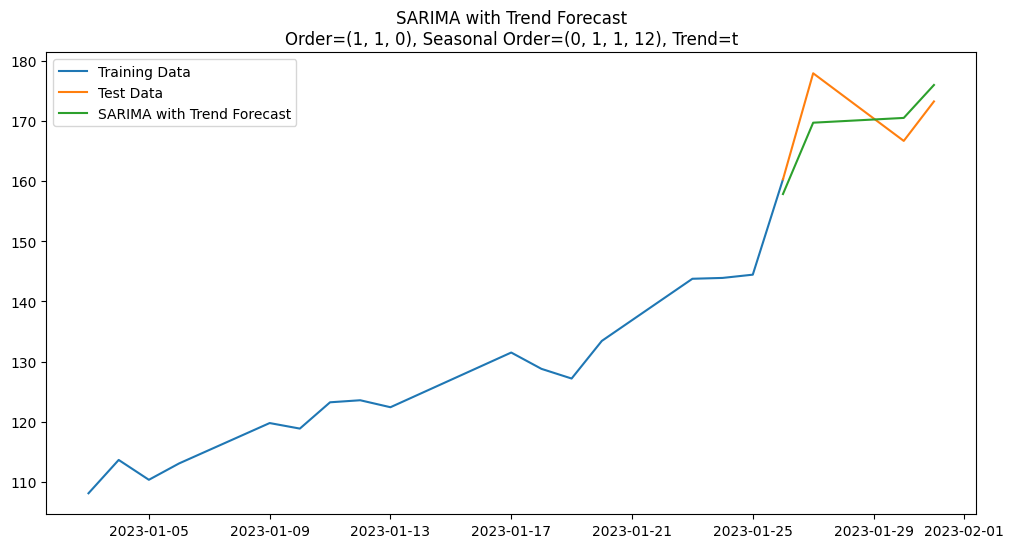

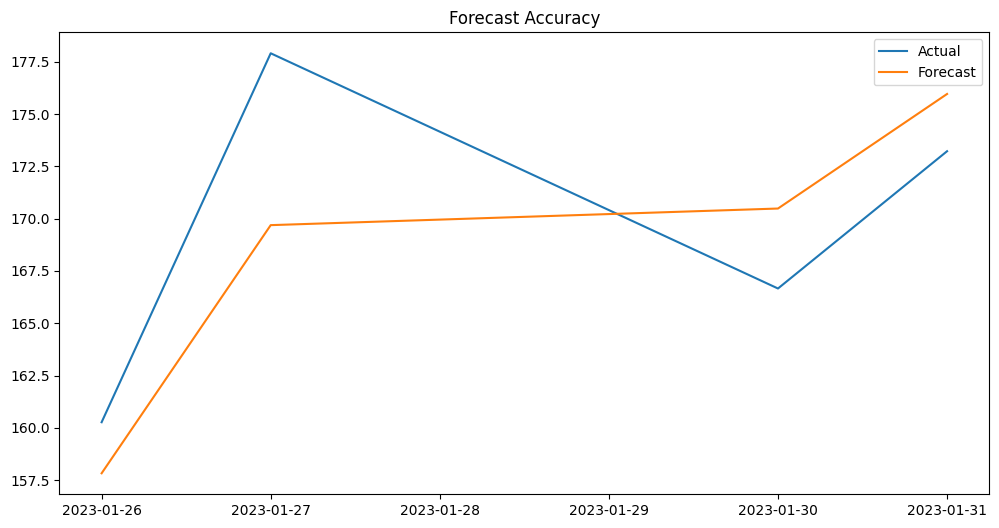

In [ ]:
sarima_trend_model.plot_results()   # Plot the SARIMA model with the trend forecast
sarima_trend_model.plot_accuracy()  # Plot the accuracy of the forecast


In [ ]:
sarima_trend_model.print_evaluation_metrics()

Best Model MSE: 23.870462186713727


In [ ]:
sarima_trend_model.display_top_orders()


Best Model Order: (1, 1, 0)
Best Seasonal Order: (0, 1, 1, 12)
Best Trend: t


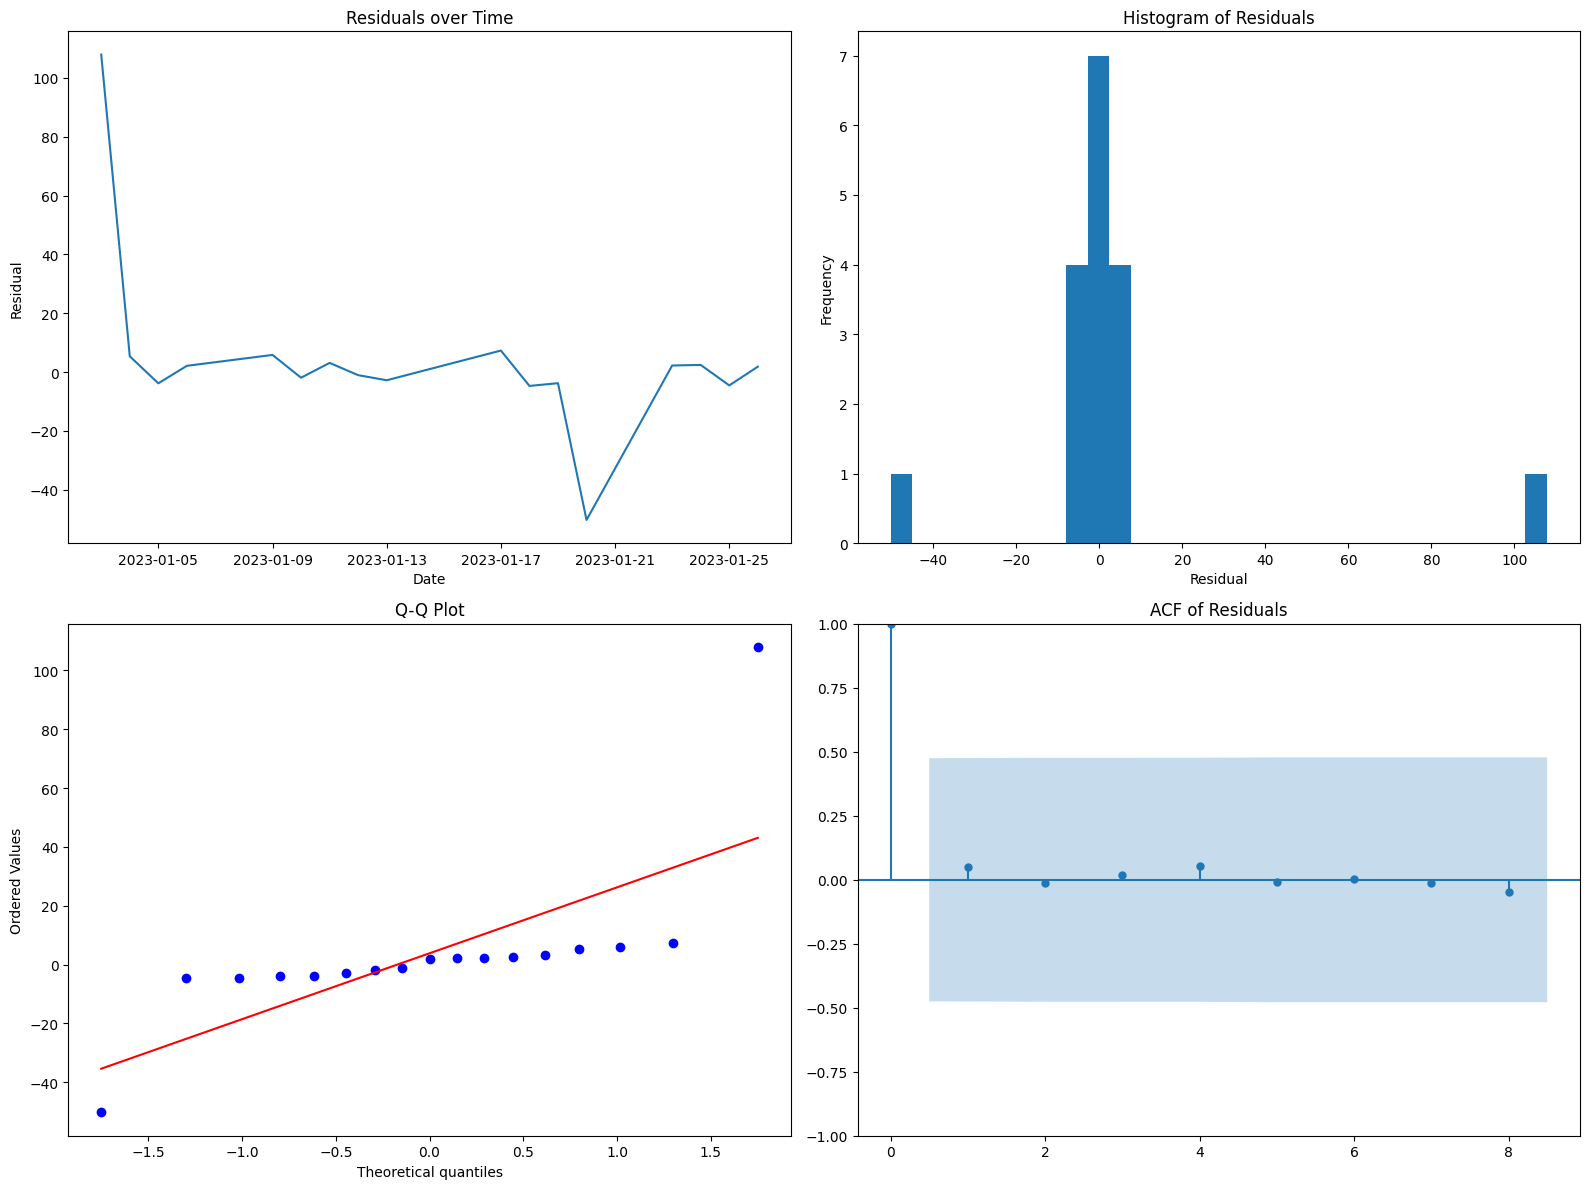

Ljung-Box test results:
    lb_stat  lb_pvalue
1  0.053346   0.817340
2  0.057382   0.971717
3  0.066502   0.995529
4  0.138045   0.997725
5  0.140403   0.999626
6  0.140568   0.999945
7  0.145686   0.999992
8  0.221023   0.999994


In [ ]:
sarima_trend_model.residual_diagnostics()


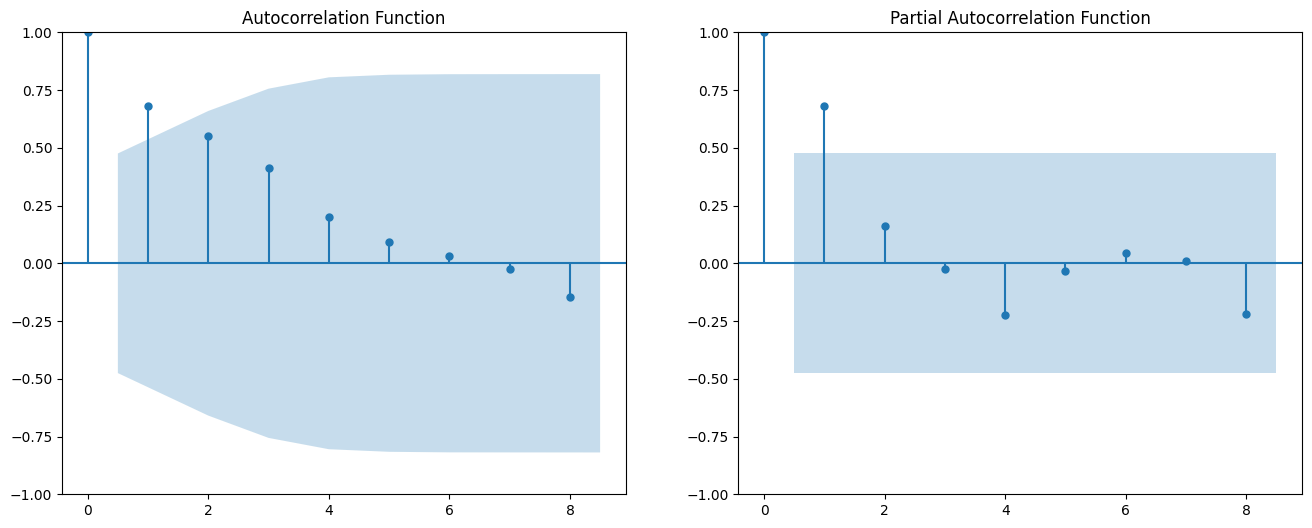

In [ ]:
sarima_trend_model.plot_acf_pacf(lags=50)


In [ ]:
forecast = sarima_trend_model.get_forecast()
print(forecast)


17    157.830485
18    169.687509
19    170.481328
20    175.955538
Name: predicted_mean, dtype: float64
